In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from wind_dir_classifier import load_netcdf
from models import data_prep, compile_and_fit, evaluate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import TimeDistributed
from sklearn.metrics import f1_score

In [ ]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df['wd_100'] = np.arctan2(df['v100'], df['u100'])
# df['wd_10'] = df['wd_10'].where(df['wd_10']>0, df['wd_10']+2*np.pi)
# df['wd_100'] = df['wd_100'].where(df['wd_100']>0, df['wd_100']+2*np.pi)

X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2014, 2020, 2021, 2021, 24, 1, y_featurename='wd_100')

# defining models
dense_regression = Sequential([
    Dense(units=200, activation='relu', input_shape=(24, X_train.shape[2])),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

compile_and_fit(dense_regression, X_train, y_train)

In [8]:
def evaluate_angular(model, X_test, y_test, scaler_y):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(np.square((testYTrue-testPredictions+np.pi)%(2*np.pi)-np.pi).mean())
    
    return testScore

In [9]:
# df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

# df['wd_10'] = np.arctan2(df['v10'], df['u10'])
# df['wd_100'] = np.arctan2(df['v100'], df['u100'])
# # df['wd_10'] = df['wd_10'].where(df['wd_10']>0, df['wd_10']+2*np.pi)
# # df['wd_100'] = df['wd_100'].where(df['wd_100']>0, df['wd_100']+2*np.pi)

# X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2014, 2020, 2021, 2021, 24, 1, y_featurename='wd_100')
y_test_original = y_test
rmse = evaluate_angular(dense_regression, X_test, y_test, scaler_y)
print("Classification RMSE = {} [rad] = {} [deg]".format(rmse, rmse*180/np.pi))

273/273 [==============================] - 1s 2ms/step
Classification RMSE = 0.43614169689874766 [rad] = 24.989078501972223 [deg]


In [2]:
from wind_dir_classifier import data_prep, compile_and_fit
from keras.utils import to_categorical

In [11]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df['wd_100'] = np.arctan2(df['v100'], df['u100'])
bins = np.linspace(-np.pi, np.pi, 9)
labels = range(8)
df['wd_100_cat'] = pd.cut(df['wd_100'], bins=bins, include_lowest=True, labels=labels)

# df['wd_100_cat'] = df['wd_100_cat'].cat.add_categories(8)
# df['wd_100_cat'] = df['wd_100_cat'].where(df['windspeed_100']>2.5, 8)

df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

# processing data for models training and evaluating
X_train, y_train, X_test, y_test = data_prep(df, trainFrom=2014, trainTo=2020, testFrom=2021, testTo=2021, lookback=24, toFuture=1, y_featurename='wd_100_cat')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

n_outputs = y_train.shape[1]

# defining models
dense = Sequential([
    Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dense(n_outputs),
    Reshape([n_outputs*24]),
    Dense(n_outputs, activation='softmax')
])

# training
history = compile_and_fit(dense, X_train, y_train, X_test, y_test)

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Epoch 1/100
1917/1917 [==============================] - 13s 6ms/step - loss: 0.8043 - accuracy: 0.7113 - val_loss: 0.6093 - val_accuracy: 0.8007
Epoch 2/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.5767 - accuracy: 0.8105 - val_loss: 0.6377 - val_accuracy: 0.7929
Epoch 3/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.5311 - accuracy: 0.8217 - val_loss: 0.5129 - val_accuracy: 0.8223
Epoch 4/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.5063 - accuracy: 0.8249 - val_loss: 0.5218 - val_accuracy: 0.8234
Epoch 5/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.4860 - accuracy: 0.8298 - val_loss: 0.4839 - val_accuracy: 0.8261
Epoch 6/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.4723 - accuracy: 0.8325 - val_loss: 0.5260 - val_accuracy: 0.8197
Epoch 7/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.4649 - accuracy: 0.8333 - val_loss: 0.5004 -

In [37]:
y_prediction = dense.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_true = np.argmax(y_test, axis=1)
y_prediction = y_prediction*45-180
y_true = y_true*45-180
rmse = sqrt(np.square((y_true-y_prediction+180)%360-180).mean())
print("Classification RMSE = {} [rad] = {} [deg]".format(rmse/180*np.pi, rmse))

273/273 [==============================] - 1s 2ms/step
Classification RMSE = 0.379181651290362 [rad] = 21.72550828773905 [deg]


In [33]:
y_prediction = dense.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_true = np.argmax(y_test, axis=1)
# y_prediction = y_prediction*45-(180-180/8)
# y_true = y_test_original * 180 / np.pi
# rmse = sqrt(np.square((y_true-y_prediction+180)%360-180).mean())
# print("Classification RMSE = {} [rad] = {} [deg]".format(rmse/180*np.pi, rmse))

273/273 [==============================] - 1s 2ms/step


In [34]:
y_prediction

array([5, 5, 5, ..., 4, 4, 4], dtype=int64)

In [36]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
bins*180/np.pi

array([-180., -135.,  -90.,  -45.,    0.,   45.,   90.,  135.,  180.])

In [21]:
a = np.arange(8)
a*45-(180-180/8)

array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5])

In [13]:
y_true = 350
y_prediction = 10
(y_true-y_prediction+180)%360-180

-20

# Number of classes study

In [4]:
noClasses = 9
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

df['wd_10'] = np.arctan2(df['v10'], df['u10'])
df['wd_100'] = np.arctan2(df['v100'], df['u100'])
bins = np.linspace(-np.pi, np.pi, noClasses)
labels = range(noClasses-1)
df['wd_100_cat'] = pd.cut(df['wd_100'], bins=bins, include_lowest=True, labels=labels)

weak_wind_class_limit = df['windspeed_100'].sort_values().iloc[int(len(df)/noClasses)]

df['wd_100_cat'] = df['wd_100_cat'].cat.add_categories(noClasses-1)
df['wd_100_cat'] = df['wd_100_cat'].where(df['windspeed_100']>weak_wind_class_limit, noClasses-1)

df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [4]:
def evaluate_model(noClasses):

    # loading needed data
    df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

    df['wd_10'] = np.arctan2(df['v10'], df['u10'])
    df['wd_100'] = np.arctan2(df['v100'], df['u100'])
    bins = np.linspace(-np.pi, np.pi, noClasses)
    labels = range(noClasses-1)
    df['wd_100_cat'] = pd.cut(df['wd_100'], bins=bins, include_lowest=True, labels=labels)

    weak_wind_class_limit = df['windspeed_100'].sort_values().iloc[int(len(df)/noClasses)]

    df['wd_100_cat'] = df['wd_100_cat'].cat.add_categories(noClasses-1)
    df['wd_100_cat'] = df['wd_100_cat'].where(df['windspeed_100']>weak_wind_class_limit, noClasses-1)

    df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)

    # processing data for models training and evaluating
    X_train, y_train, X_test, y_test = data_prep(df, trainFrom=2014, trainTo=2020, testFrom=2021, testTo=2021, lookback=24, toFuture=1, y_featurename='wd_100_cat')
    y_test_mod = y_test.flatten().astype('int64')
    correction = ((np.bincount(y_test_mod)/len(y_test_mod))**2).sum()
    print("Correction = {}".format(correction))

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    n_outputs = y_train.shape[1]
    print(y_train.shape)

    # defining models
    dense = Sequential([
        Dense(units=200, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(units=200, activation='relu'),
        Dropout(0.2),
        Dense(units=200, activation='relu'),
        Dense(n_outputs),
        Reshape([n_outputs*24]),
        Dense(n_outputs, activation='softmax')
    ])

    # training
    history = compile_and_fit(dense, X_train, y_train, X_test, y_test)

    _, accuracy = dense.evaluate(X_test, y_test, batch_size=32, verbose=0)

    y_prediction = dense.predict(X_test)
    y_prediction = np.argmax (y_prediction, axis = 1)
    y_true = np.argmax(y_test, axis=1)
    f_score = f1_score(y_true, y_prediction, average='weighted')
    # y_prediction = y_prediction*45-(180-180/8)
    # y_true = y_test_original * 180 / np.pi
    # rmse = sqrt(np.square((y_true-y_prediction+180)%360-180).mean())
    # print("Classification RMSE = {} [rad] = {} [deg]".format(rmse/180*np.pi, rmse))

    return accuracy, dense, correction, f_score
    # return correction

In [ ]:
accuracies = []
noClasses = []
models = []
corrections = []
f_scores = []

for i in range(3, 34, 1):
    corr = evaluate_model(i)
    noClasses.append(i)
    corrections.append(corr)

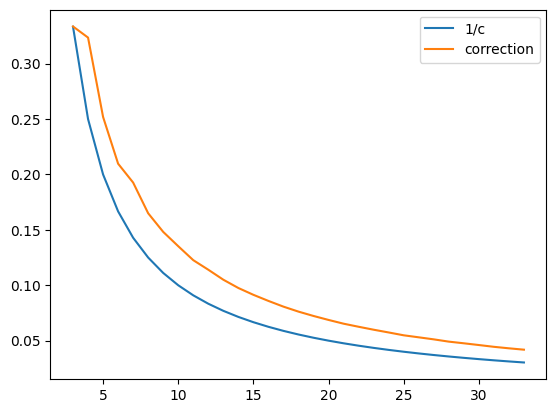

In [9]:
plt.plot(noClasses, np.divide(1,noClasses))
plt.plot(noClasses, corrections)
plt.legend(['1/c', 'correction'])

Wykres poprawki vs 1/c \
Scatterplot f1 dla kazdej z klas

In [48]:
accuracies = []
noClasses = []
models = []
corrections = []
f_scores = []

for i in range(3, 17, 2):
    acc, model, corr, f_score = evaluate_model(i)
    print(acc)
    models.append(model)
    accuracies.append(acc)
    noClasses.append(i)
    corrections.append(corr)
    f_scores.append(f_score)

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.3335545996096342
(61343, 3)
Epoch 1/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.3533 - accuracy: 0.8846 - val_loss: 0.2881 - val_accuracy: 0.9035
Epoch 2/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2740 - accuracy: 0.9076 - val_loss: 0.2627 - val_accuracy: 0.9027
Epoch 3/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2580 - accuracy: 0.9082 - val_loss: 0.2697 - val_accuracy: 0.9064
Epoch 4/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2476 - accuracy: 0.9112 - val_loss: 0.2483 - val_accuracy: 0.9075
Epoch 5/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2407 - accuracy: 0.9119 - val_loss: 0.2402 - val_accuracy: 0.9104
Epoch 6/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2350 - accuracy: 0.9129 - val_loss: 0.2412 - val_accuracy: 0.9062
Epoch 7/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.2

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.2519105153359639
(61343, 5)
Epoch 1/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.4945 - accuracy: 0.8438 - val_loss: 0.3975 - val_accuracy: 0.8825
Epoch 2/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.3623 - accuracy: 0.8888 - val_loss: 0.3474 - val_accuracy: 0.8879
Epoch 3/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.3337 - accuracy: 0.8912 - val_loss: 0.3101 - val_accuracy: 0.8930
Epoch 4/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.3174 - accuracy: 0.8939 - val_loss: 0.3046 - val_accuracy: 0.8911
Epoch 5/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.3107 - accuracy: 0.8946 - val_loss: 0.3020 - val_accuracy: 0.8924
Epoch 6/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.3010 - accuracy: 0.8949 - val_loss: 0.3067 - val_accuracy: 0.8951
Epoch 7/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.2

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.19267231518648864
(61343, 7)
Epoch 1/100
1917/1917 [==============================] - 16s 8ms/step - loss: 0.6618 - accuracy: 0.7841 - val_loss: 0.4981 - val_accuracy: 0.8535
Epoch 2/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.4725 - accuracy: 0.8581 - val_loss: 0.4316 - val_accuracy: 0.8650
Epoch 3/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.4415 - accuracy: 0.8630 - val_loss: 0.4182 - val_accuracy: 0.8634
Epoch 4/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.4171 - accuracy: 0.8657 - val_loss: 0.4035 - val_accuracy: 0.8674
Epoch 5/100
1917/1917 [==============================] - 14s 8ms/step - loss: 0.4029 - accuracy: 0.8667 - val_loss: 0.4138 - val_accuracy: 0.8604
Epoch 6/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.3919 - accuracy: 0.8679 - val_loss: 0.3861 - val_accuracy: 0.8694
Epoch 7/100
1917/1917 [==============================] - 15s 8ms/step - loss: 0.

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.14816594577538925
(61343, 9)
Epoch 1/100
1917/1917 [==============================] - 15s 7ms/step - loss: 0.8325 - accuracy: 0.7117 - val_loss: 0.6621 - val_accuracy: 0.7928
Epoch 2/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.5993 - accuracy: 0.8141 - val_loss: 0.5739 - val_accuracy: 0.8252
Epoch 3/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.5547 - accuracy: 0.8261 - val_loss: 0.5504 - val_accuracy: 0.8263
Epoch 4/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.5247 - accuracy: 0.8317 - val_loss: 0.5085 - val_accuracy: 0.8309
Epoch 5/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.5071 - accuracy: 0.8332 - val_loss: 0.4884 - val_accuracy: 0.8355
Epoch 6/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.4913 - accuracy: 0.8342 - val_loss: 0.5203 - val_accuracy: 0.8306
Epoch 7/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.1226465977000723
(61343, 11)
Epoch 1/100
1917/1917 [==============================] - 13s 7ms/step - loss: 1.0199 - accuracy: 0.6270 - val_loss: 0.8003 - val_accuracy: 0.7334
Epoch 2/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.7267 - accuracy: 0.7573 - val_loss: 0.6927 - val_accuracy: 0.7753
Epoch 3/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.6662 - accuracy: 0.7800 - val_loss: 0.6482 - val_accuracy: 0.7868
Epoch 4/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.6331 - accuracy: 0.7878 - val_loss: 0.6463 - val_accuracy: 0.7847
Epoch 5/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.6129 - accuracy: 0.7918 - val_loss: 0.6081 - val_accuracy: 0.7898
Epoch 6/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.5991 - accuracy: 0.7954 - val_loss: 0.5994 - val_accuracy: 0.7904
Epoch 7/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.10499765891909231
(61343, 13)
Epoch 1/100
1917/1917 [==============================] - 14s 7ms/step - loss: 1.1737 - accuracy: 0.5547 - val_loss: 0.8941 - val_accuracy: 0.6950
Epoch 2/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.8487 - accuracy: 0.7027 - val_loss: 0.8394 - val_accuracy: 0.7154
Epoch 3/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.7783 - accuracy: 0.7314 - val_loss: 0.7504 - val_accuracy: 0.7492
Epoch 4/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.7377 - accuracy: 0.7441 - val_loss: 0.7209 - val_accuracy: 0.7566
Epoch 5/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.7144 - accuracy: 0.7527 - val_loss: 0.7117 - val_accuracy: 0.7564
Epoch 6/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.6991 - accuracy: 0.7545 - val_loss: 0.6895 - val_accuracy: 0.7590
Epoch 7/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


Correction = 0.09137769908280088
(61343, 15)
Epoch 1/100
1917/1917 [==============================] - 13s 7ms/step - loss: 1.3328 - accuracy: 0.4873 - val_loss: 1.0350 - val_accuracy: 0.6164
Epoch 2/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.9702 - accuracy: 0.6397 - val_loss: 0.8939 - val_accuracy: 0.6813
Epoch 3/100
1917/1917 [==============================] - 14s 7ms/step - loss: 0.8889 - accuracy: 0.6780 - val_loss: 0.8530 - val_accuracy: 0.6958
Epoch 4/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.8436 - accuracy: 0.6969 - val_loss: 0.8314 - val_accuracy: 0.7068
Epoch 5/100
1917/1917 [==============================] - 13s 7ms/step - loss: 0.8161 - accuracy: 0.7069 - val_loss: 0.7838 - val_accuracy: 0.7211
Epoch 6/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0.7952 - accuracy: 0.7116 - val_loss: 0.7697 - val_accuracy: 0.7189
Epoch 7/100
1917/1917 [==============================] - 12s 6ms/step - loss: 0

Text(0, 0.5, 'Accuracy')

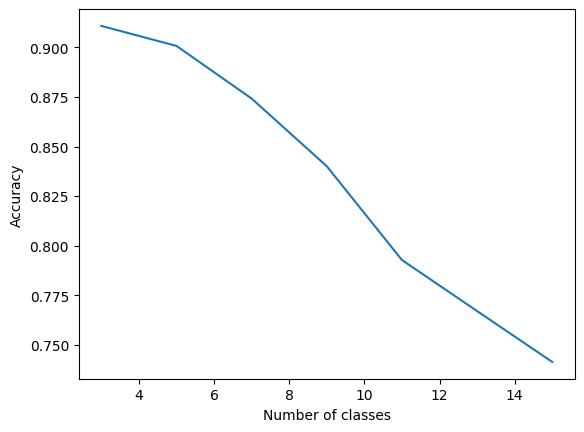

In [49]:
plt.plot(noClasses, accuracies)
plt.xlabel("Number of classes")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy / correction')

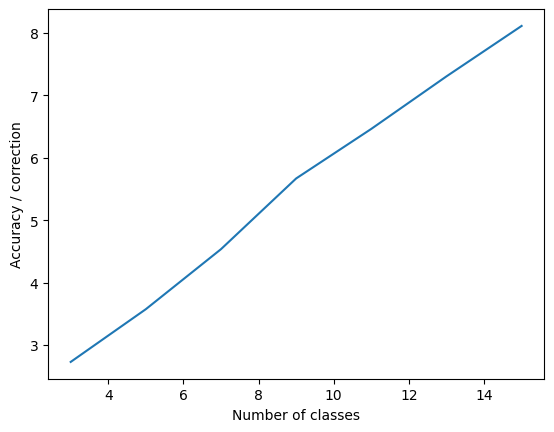

In [50]:
plt.plot(noClasses, np.divide(accuracies, corrections))
plt.xlabel("Number of classes")
plt.ylabel("Accuracy / correction")

Text(0, 0.5, 'F1 score')

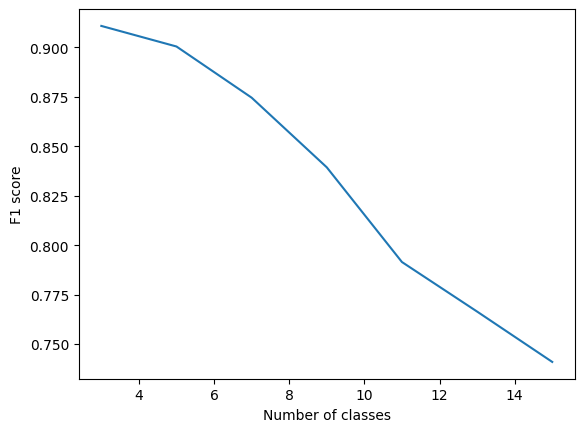

In [51]:
plt.plot(noClasses, f_scores)
plt.xlabel("Number of classes")
plt.ylabel("F1 score")

# Direction by speed components

In [59]:
from sklearn.preprocessing import MinMaxScaler

def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

def to_supervised(data, n_input, n_out, y_index):
    X, y1, y2 = list(), list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y1.append(data[out_end-1, y_index[0]])
            y2.append(data[out_end-1, y_index[1]])
        # move along one time step
        in_start += 1
    return np.array(X), np.array([y1, y2]).reshape((len(y1),2))

def data_prep(df, trainFrom, trainTo, testFrom, testTo, lookback, toFuture, y_featurename):
    train = df[df['Date Time']>='{}-01-01'.format(trainFrom)]
    train = train[train['Date Time']<'{}-01-01'.format(trainTo+1)]
    test = df[df['Date Time']>='{}-01-01'.format(testFrom)]
    test = test[test['Date Time']<'{}-01-01'.format(testTo+1)]

    train = datetimeToSignal(train)
    test = datetimeToSignal(test)
    
    y_indexes = [train.columns.get_loc(feature) for feature in y_featurename]
    print(y_indexes)

    values_train = train.values
    values_test = test.values

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values_train)
    # scaler_y = MinMaxScaler(feature_range=(0, 1))
    # scaler_y.fit(values_train[:,y_index].reshape(len(values_train),1))

    values_train = scaler.transform(values_train)
    values_test = scaler.transform(values_test)

    X_train, y_train = to_supervised(values_train, n_input=lookback, n_out=toFuture, y_index=y_indexes)
    X_test, y_test = to_supervised(values_test, n_input=lookback, n_out=toFuture, y_index=y_indexes)

    return X_train, y_train, X_test, y_test

In [66]:
## loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

# df['wd_10'] = np.arctan2(df['v10'], df['u10'])
# df['wd_100'] = np.arctan2(df['v100'], df['u100'])
# df['wd_10'] = df['wd_10'].where(df['wd_10']>0, df['wd_10']+2*np.pi)
# df['wd_100'] = df['wd_100'].where(df['wd_100']>0, df['wd_100']+2*np.pi)

X_train, y_train, X_test, y_test = data_prep(df, 2014, 2020, 2021, 2021, 24, 1, y_featurename=['u10', 'v10'])

# defining models
dense_regression = Sequential([
    Dense(units=200, activation='relu', input_shape=(24, X_train.shape[2])),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(units=200, activation='relu'),
    Dropout(0.2),
    Dense(2),
    Reshape([2,24]),
    Dense(1),
    Reshape([2]),
])
dense_regression.summary()

compile_and_fit(dense_regression, X_train, y_train)

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


[4, 5]
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 24, 200)           3200      
                                                                 
 dropout_82 (Dropout)        (None, 24, 200)           0         
                                                                 
 dense_155 (Dense)           (None, 24, 200)           40200     
                                                                 
 dropout_83 (Dropout)        (None, 24, 200)           0         
                                                                 
 dense_156 (Dense)           (None, 24, 200)           40200     
                                                                 
 dropout_84 (Dropout)        (None, 24, 200)           0         
                                                                 
 dense_157 (Dense)           (None, 24, 2)    

In [67]:
pred = dense_regression.predict(X_test)

273/273 [==============================] - 1s 2ms/step


In [68]:
pred

array([[0.35957056, 0.51224065],
       [0.3827056 , 0.5076072 ],
       [0.40719822, 0.5023119 ],
       ...,
       [0.47142917, 0.44664478],
       [0.4667135 , 0.44574577],
       [0.45587963, 0.44036376]], dtype=float32)

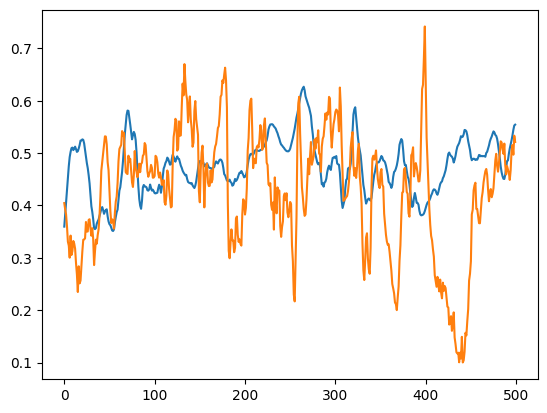

In [72]:
plt.plot(pred[:500,0])
plt.plot(y_test[:500,0])